
# <b><div style="color:#211894;font-size:100%;text-align:center">欢迎来到黑客松计算机视觉分赛道！ | Welcome to the Computer Vision Track of the Hackathon! 👁</div></b>

# <a id="TOC">目录 | Table of Contents</a> 
- [1. 简介 | Introduction](#1)  
    - [1.1 学习目标 | Learning Objectives ](#1_1)
    - [1.2 导入库 | Import Libraries](#1_2)
    - [1.3 VGG16 模型简介 | Introduction to VGG16 Model](#1_3)
    - [1.4 硬件组件 | Hardware Component](#1_4)
    - [1.5 软件组件  | Software Component](#1_5)
- [2. 探索性数据分析 | Exploratory Data Analysis](#2)
- [3. 定义定制化 VGG-16 模型 | Defining Custom VGG-16 Model](#3)  
- [4. 使用 AI 分析工具套件 - 英特尔&reg; PyTorch* 扩展进行迁移学习 | Transfer Learning with the AI Analytics Toolkit - Intel&reg; Extention for PyTorch*](#4)
- [5. 使用 Intel® Neural Compressor 量化模型](#5)
- [6. 在 Intel® oneAPI DevCloud 上运行 | Run on oneAPI DevCloud](#6)
- [7. 总结与学习 | Summary and Learnings](#7)

# <a class="anchor" id="1"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">1 | 简介 | Introduction</div></a>


在本 notebook 中，我们将介绍<b>[视觉质量检测 AI 参考套件](https://github.com/oneapi-src/visual-quality-inspection)</b>，并展示如何将英特尔优化库用于机器学习，助您赢得黑客马拉松！参考套件 GitHub 页面提供了各种数据集的链接，核心理念是在制造过程中对缺陷产品进行视觉检查。未来，您可以将这项技术用于牙刷、瓷砖、木材等的检查，但是本 notebook 将重点讨论药片的质量。在该数据集中，面向消费者的非处方药被分类为品质良好和有缺陷两种类别。有缺陷的药片是指包含缺口、裂缝或形状不规则的药片。


In this notebook, we'll introduce the <b>[Visual Quality Inspection AI Reference Kit](https://github.com/oneapi-src/visual-quality-inspection)</b> and show you how to use Intel-optimized libraries for machine learning so you can win the Hackathon! The reference kit GitHub page provides a link to various datasets that all revolve around the concept of visually inspecting damaged products in the manufacturing process. In the future, you could play around with toothbrush, tiles, wood, etc. but in this notebook we will focus on pill quality. In this dataset, consumer over the counter medicial supplements are classfified into good or bad categories. Bad pills are ones that contain chips, cracks, or mishapen features. 

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.1 | 学习目标 | Learning Objectives</span></a></b>

借助该视觉质量检测数据集，您将使用英特尔 oneAPI 工具套件构建一个端到端的机器学习流水线，以优化训练周期、预测吞吐量和准确率。我们将使用的主要组件是<b>[英特尔® PyTorch* 扩展](https://pytorch.org/tutorials/recipes/recipes/intel_extension_for_pytorch.html)</b>。

Given this Visual Quality Inspection dataset, you'll build an end-to-end Machine Learning pipeline using Intel's oneAPI toolkits to optimize the training cycles, prediction throughput, and accuracy. The main component we'll be working with is <b>[Intel&reg; extension for PyTorch*](https://pytorch.org/tutorials/recipes/recipes/intel_extension_for_pytorch.html)</b>.

## <b><a class="anchor" id="1_2"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.2 | 导入库 | Import Libraries</span></a></b>


In [ ]:
import os
import sys
import time
import argparse
import itertools
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import intel_extension_for_pytorch as ipex
import pandas as pd 

from torch import nn
from torch import optim
from torch.autograd import Variable
from torchvision import models
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
from sklearn.model_selection import train_test_split, StratifiedKFold

# adding src to path 
module_path = os.path.abspath(os.path.join('./src'))
if module_path not in sys.path:
    sys.path.append(module_path)

# utilities
from src.utils.dataloader import get_train_test_loaders
from src.utils.helper import train, evaluate, predict_localize
from src.utils.dataloader import get_train_test_loaders

## <b><a class="anchor" id="1_3"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.3 | VGG16 模型简介 | Introduction to VGG16 Model</span></a></b>


VGG-16 是一个 16 层深的卷积神经网络，作为分类架构，用于对生产管道中的优良样本和缺陷样本进行分类。英特尔® PyTorch* 扩展可在药片数据集的基础上，对 VGGNet 分类架构进行迁移学习。我们在 VGGNet 的常见 PyTorch 版本中进行了相同的试验。

VGG-16 is a convolutional neural network that is 16 layers deep and same has been used as classification architecture to classify the good and defect samples from the production pipeline. Intel® Extension for PyTorch* is used for transfer learning the VGGNet classification architecture on the pill dataset created. Same experiment performed in stock PyTorch version of VGGNet.

VGG-16 是 2014 年 ILSVRC 挑战赛中性能最高的架构之一。它在分类任务中获得了亚军，前 5 个分类误差为 7.32%（仅次于 GoogLeNet，其分类误差为 6.66%）。它还是定位任务比赛的冠军，定位误差为 25.32%。

VGG-16 was one of the best performing architectures in the ILSVRC challenge 2014. It was the runner up in the classification task with a top-5 classification error of 7.32% (only behind GoogLeNet with a classification error of 6.66%). It was also the winner of localization task with 25.32% localization error.

VGG 16 的局限  | Limitations Of VGG 16:

- 从头开始训练非常缓慢。 | It is very slow to train from scratch.
- VGG-16 训练的 imageNet 权重大小为 528 MB，因此需要占用大量磁盘空间和带宽，效率低下。 | The size of VGG-16 trained imageNet weights is 528 MB. So, it takes quite a lot of disk space and bandwidth which makes it inefficient.
- 1.38 亿个参数将造成梯度爆炸问题。 | 138 million parameters lead to exploding gradients problem.

**一些实用资源 | Some Helpful Resources**: 
- VGG16 论文链接 | Link to VGG16 paper: https://arxiv.org/abs/1409.1556
- GeekforGeeks 文章链接 | Link to GeekforGeeks Article: https://www.geeksforgeeks.org/vgg-16-cnn-model/

## <b><a class="anchor" id="1_4"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.4 | 硬件组件 | Hardware Component</span></a></b>

在黑客马拉松的本次活动中，我们推荐使用第三代英特尔® 至强® 系列处理器或第四代至强® 系列处理器，AVX-512 矢量神经网络指令 (AVX512 VNNI) 和英特尔® 高级矩阵扩展（英特尔® AMX）配合相应的软件及如Intel® Neural Compressor 等组件能实现更好的性能，第三代至强® 系列处理器 Ice Lake CPU 架构，是很多主流云服务提供商都在使用的硬件。参赛人员可以利用英特尔免费为您提供的 [oneAPI DevCloud云测试环境](https://devcloud.intel.com/oneapi/) 中的各种硬件及计算能力，或利用自己的笔记本或其他适合的硬件环境作为比赛代码的开发、验证和最终代码递交的测试环境。 

In this track of the Hackathon, we recommend to use a 3rd Generation or 4th Generation Intel&reg; Xeon&reg; based processor, software compoents such as Intel® Neural Compressor with take advantage of AVX-512 Vector Neural Network Instructions (AVX512 VNNI) and Intel® Advanced Matrix Extensions (Intel® AMX) by deliver better preformance. 3rd Generation ntel Intel&reg; Xeon&reg; based processor - which is an Ice Lake CPU, is a popular hardware platform adopted by mainstream cloud servcie providers. The participants can also utilize the free [oneAPI Developer Cloud](https://devcloud.intel.com/oneapi/) test environment and its hardware and computing capabilities, your own notebook or other appropriate development platform for code development, validataion and as your final test platform for code submission.

通过下面的命令，可以查看硬件环境中对应CPU的相应硬件能力 (仅作为示例)

Through the below command, user will be able to view the hardware capability of the respective CPU （for illustration purpose only）


In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  16
  On-line CPU(s) list:   0-15
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Platinum 8375C CPU @ 2.90GHz
    CPU family:          6
    Model:               106
    Thread(s) per core:  2
    Core(s) per socket:  8
    Socket(s):           1
    Stepping:            6
    BogoMIPS:            5799.92
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid aperfmperf tsc_known_freq pni pc
                         lmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe 
                         popcnt tsc_deadline_timer aes xsave 

## <b><a class="anchor" id="1_5"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">1.5 | 软件组件 | Software Component</span></a></b>

##### 本节比较了标准版本的 PyTorch 1.8.0 和英特尔®  PyTorch* 扩展 (IPEX) 1.8.0 在模型预测时间方面的差异。 | This section covers the prediction time comparison between Stock PyTorch 1.8.0 and Intel® Extension for PyTorch* (IPEX) 1.8.0 for this model.

要点 | Key Takeaways

- 结果显示，相比标准版本的 Pytorch 1.8.0，IPEX 1.8.0 将药片异常检测模型的实时预测时间加快了 2.22 倍 | Realtime prediction time speedup with IPEX 1.8.0 shows up to 2.22x against stock Pytorch 1.8.0 for the Pill anomaly detection model
- 相比标准版本的 Pytorch 1.8.0，IPEX 1.8.0 将药片异常检测模型的批量预测时间加快了 1.04 倍到 1.38 倍不等 | Batch prediction time speedup with IPEX 1.8.0 shows from 1.04x to 1.38x against stock Pytorch 1.8.0 for the Pill anomaly detection model

<img src="nb_imgs/pytorch_prediction_time.png" style="border-radius:15px">

#### 英特尔架构上的 PyTorch 和 IPEX 将带来哪些优势？ | What benefits do you get from PyTorch on Intel and IPEX? 

英特尔® PyTorch*扩展为 PyTorch 提供了额外的优化，旨在提升英特尔硬件上的性能。大多数优化最终将在常见的标准 PyTorch 版本中发布。扩展的目的是为 PyTorch 提供最新的英特尔硬件特性和优化，例如 AVX-512 矢量神经网络指令 (AVX512 VNNI) 和英特尔® 高级矩阵扩展（英特尔® AMX）。

Intel® Extension for PyTorch* extends PyTorch with optimizations for extra performance boost on Intel hardware. Most of the optimizations will be included in stock PyTorch releases eventually, and the intention of the extension is to deliver up to date features and optimizations for PyTorch on Intel hardware, examples include AVX-512 Vector Neural Network Instructions (AVX512 VNNI) and Intel® Advanced Matrix Extensions (Intel® AMX).

英特尔®PyTorch*扩展已作为开源项目，在 Github 上发布。

Intel® Extension for PyTorch* has been released as an open–source project at Github.

#### 特性 | Features

- 易于使用的 Python API：英特尔®PyTorch*扩展提供了简单的前端 Python API 和实用程序，用户只需对代码稍作修改，便可实现图优化、算子优化等性能优化。通常只需在原始代码中增加 2 到 3 个子句。
- Channels Last：相比默认的 NCHW 内存格式，channels_last (NHWC) 内存格式将进一步加速卷积神经网络。在英特尔®PyTorch*扩展中，为大多数关键 CPU 算子启用 NHWC 内存格式，尽管它们还没有被全部合并到 PyTorch 主分支中，预计很快将完全部署至 PyTorch 上游。
- 自动混合精度 (AMP)：内置 AVX512 指令集的第三代至强可扩展服务器（即 Cooper Lake）原生支持低精度数据类型 BFloat16，内置英特尔® 高级矩阵扩展（英特尔® AMX）指令集的新一代英特尔® 至强® 可扩展处理器将继续支持该类型，以进一步提升性能。自动混合精度 (AMP) 支持（包括面向 CPU 的 BFloat16 和算子的 BFloat16 优化）已在英特尔®PyTorch*扩展中大规模启用，并且部分部署到上游的 PyTorch 主分支。PR 正在提交和审核中，很快大多数优化将登陆 PyTorch 主分支。
- 图优化：为了进一步优化 torchscript 的性能，英特尔®PyTorch*扩展支持融合常用的算子模式，如 Conv2D+ReLU，线性+ReLU 等，并以透明的方式为用户带来融合的优势。如欲详细了解支持的融合模式，请参见此处。通过引入 oneDNN Graph API，将图优化部署到上游的 PyTorch。
- 算子优化：英特尔®PyTorch* 扩展 还对算子进行了优化，并实现了多个定制算子，以提升性能。通过 ATen 注册机制，多个 ATen 算子会被英特尔®PyTorch*扩展中的优化版本所取代。此外，针对多个主流拓扑实现了定制算子，例如，在 Mask R-CNN 中定义 ROIAlign 和 NMS。为了提升拓扑的性能，英特尔®PyTorch*扩展还优化了这些定制算子。


- Ease-of-use Python API: Intel® Extension for PyTorch* provides simple frontend Python APIs and utilities for users to get performance optimizations such as graph optimization and operator optimization with minor code changes. Typically, only 2 to 3 clauses are required to be added to the original code.
- Channels Last: Comparing to the default NCHW memory format, channels_last (NHWC) memory format could further accelerate convolutional neural networks. In Intel® Extension for PyTorch*, NHWC memory format has been enabled for most key CPU operators, though not all of them have been merged to PyTorch master branch yet. They are expected to be fully landed in PyTorch upstream soon.
- Auto Mixed Precision (AMP): Low precision data type BFloat16 has been natively supported on the 3rd Generation Xeon scalable Servers (aka Cooper Lake) with AVX512 instruction set and will be supported on the next generation of Intel® Xeon® Scalable Processors with Intel® Advanced Matrix Extensions (Intel® AMX) instruction set with further boosted performance. The support of Auto Mixed Precision (AMP) with BFloat16 for CPU and BFloat16 optimization of operators have been massively enabled in Intel® Extension for PyTorch*, and partially upstreamed to PyTorch master branch. Most of these optimizations will be landed in PyTorch master through PRs that are being submitted and reviewed.
- Graph Optimization: To optimize performance further with torchscript, Intel® Extension for PyTorch* supports fusion of frequently used operator patterns, like Conv2D+ReLU, Linear+ReLU, etc. The benefit of the fusions are delivered to users in a transparent fashion. Detailed fusion patterns supported can be found here. The graph optimization will be up-streamed to PyTorch with the introduction of oneDNN Graph API.
- Operator Optimization: Intel® Extension for PyTorch* also optimizes operators and implements several customized operators for performance. A few ATen operators are replaced by their optimized counterparts in Intel® Extension for PyTorch* via ATen registration mechanism. Moreover, some customized operators are implemented for several popular topologies. For instance, ROIAlign and NMS are defined in Mask R-CNN. To improve performance of these topologies, Intel® Extension for PyTorch* also optimized these customized operators.

# <a class="anchor" id="2"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">2 | 探索性数据分析 | Exploratory Data Analysis</div></a>

#### 对于制药行业，质量控制是一个非常重要的环节。我们来看一下区分合格药片和有缺陷药片的不同方面。 | Quality control in the pharmaceutical industry is a very critical component. Let’s look at the different aspects of acceptable and defective pills. 


我们可以预料到的缺陷有：
- 颜色
- 污染
- 裂缝
- 印记错误
- 药片类型错误
- 划痕

Some of the defects that we can expect: 
- color 
- contamination 
- crack
- fault imprint
- wrong pill type
- scratches

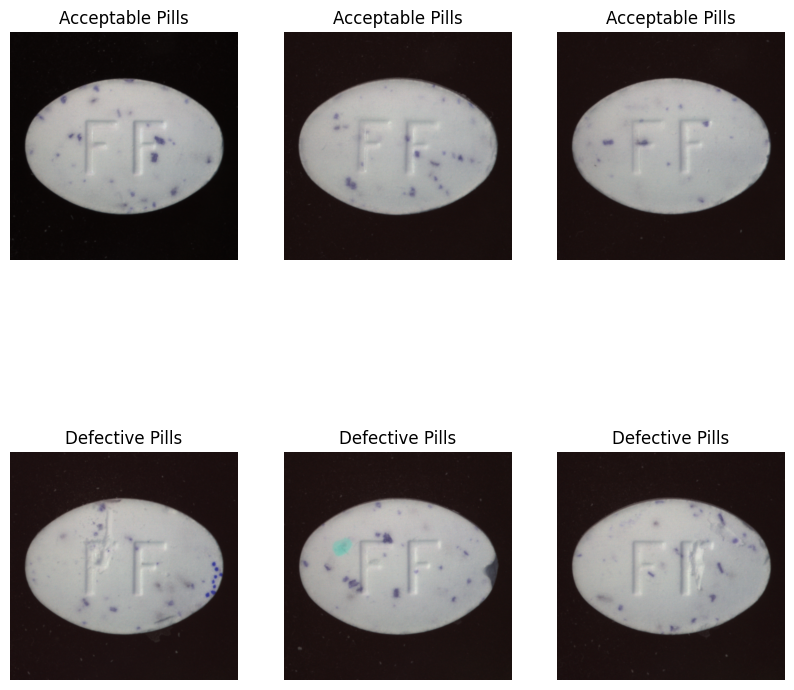

Number of Acceptable Samples 210
Number of Defective Samples 17


In [2]:
import cv2

train_dir = './data/train' # image folder

# get the list of jpegs from sub image class folders
good_imgs = [fn for fn in os.listdir(f'{train_dir}/good') if fn.endswith('.png')]
bad_imgs = [fn for fn in os.listdir(f'{train_dir}/bad') if fn.endswith('.png')]

# randomly select 3 of each
select_norm = np.random.choice(good_imgs, 3, replace = False)
select_pneu = np.random.choice(bad_imgs, 3, replace = False)

# plotting 2 x 3 image matrix
fig = plt.figure(figsize = (10,10))
for i in range(6):
    if i < 3:
        fp = f'{train_dir}/good/{select_norm[i]}'
        label = 'Acceptable Pills'
    else:
        fp = f'{train_dir}/bad/{select_pneu[i-3]}'
        label = 'Defective Pills'
    ax = fig.add_subplot(2, 3, i+1)
    
    # to plot without rescaling, remove target_size
    fn = cv2.imread(fp)
    fn_gray = cv2.cvtColor(fn, cv2.COLOR_BGR2GRAY)
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')
plt.show()

# also check the number of files here
print(f'Number of Acceptable Samples {len(good_imgs)}')
print(f'Number of Defective Samples {len(bad_imgs)}')

#### 将图像转换为 numpy 数组，以进行深入分析 | Convert images to numpy arrays for deeper analysis

In [3]:
# making n X m matrix
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = cv2.imread(fp)
        current_image = cv2.cvtColor(current_image, cv2.COLOR_BGR2GRAY)
        
        # covert image to a matrix
   #    img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [current_image.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

# run it on our folders
good_images = img2np(f'{train_dir}/good/', good_imgs)
bad_images = img2np(f'{train_dir}/bad/', bad_imgs)

#### “合格”和“有缺陷”药片的统计视觉分析 | Statistical-Visual analysis of "Acceptable" and "Defective" Pills

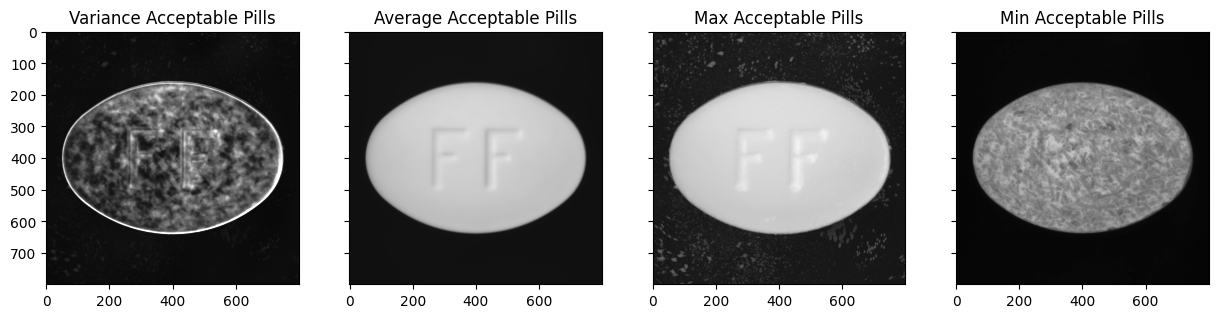

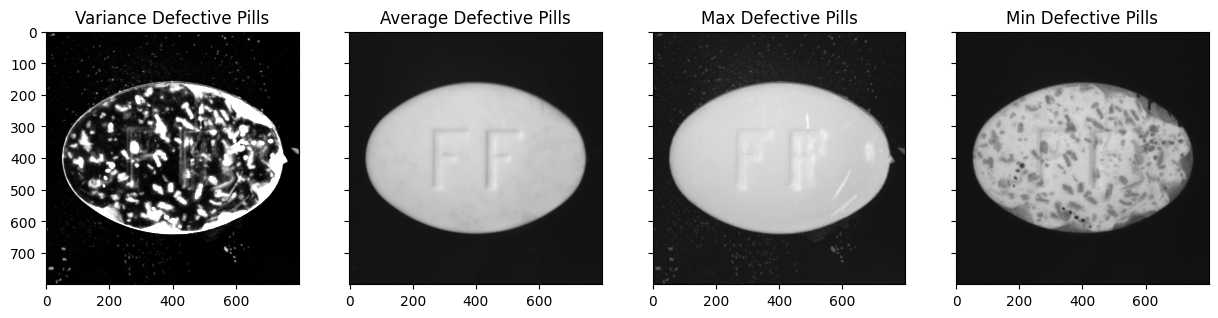

In [4]:
def find_stat_img(full_mat, title, size = (800, 800)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    mean_img = mean_img.reshape(size)
    var_img = np.var(full_mat, axis = 0)
    var_img = var_img.reshape(size)
    max_img = np.amax(full_mat, axis = 0)
    max_img = max_img.reshape(size)
    min_img = np.amin(full_mat, axis = 0)
    min_img = min_img.reshape(size)
    
    figure, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(15, 15))
    ax1.imshow(var_img, vmin=0, vmax=255, cmap='Greys_r')
    ax1.set_title(f'Variance {title}')
    ax2.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    ax2.set_title(f'Average {title}')
    ax3.imshow(max_img, vmin=0, vmax=255, cmap='Greys_r')
    ax3.set_title(f'Max {title}')
    ax4.imshow(min_img, vmin=0, vmax=255, cmap='Greys_r')
    ax4.set_title(f'Min {title}')
    plt.show()
    return mean_img, var_img

good_mean, good_var = find_stat_img(good_images, 'Acceptable Pills')
bad_mean, bad_var = find_stat_img(bad_images, 'Defective Pills')

#### “合格”和“有缺陷”药片的平均差异显示最常出现缺陷的区域。 | The difference between the average "Acceptable" and "Defective" pills indicates the ares most often aflicted by defects.

经过分析发现，合格和缺陷药片的主要差异在于药片右上角的一个小缺陷，药片右侧好像变色了。这表明制造过程中出现的某个问题使部分药片右侧受损。

We see from this analysis that the main difference between Acceptable and Defective pills is a small defect in the upper right of the pills and what appears to be discoloration on the right side of the pill. This could indicate an issue with the manufacturing process that damages the right side of some pills. 

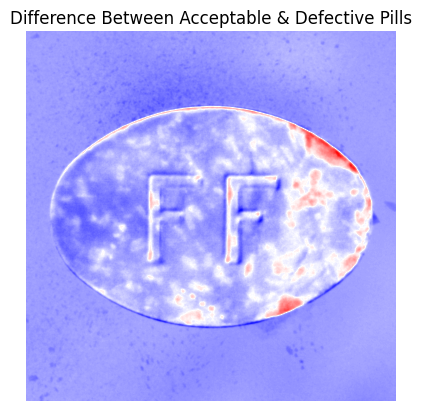

In [9]:
contrast_mean = good_mean - bad_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Acceptable & Defective Pills')
plt.axis('off')
plt.show()

# <a class="anchor" id="3"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">3 | VGG-16 模型定义 | VGG-16 Model Definition</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.1 | VGG-16 模型 | VGG-16 Model</span></a></b>

一个采用 VGG16 特征提取器的自定义多类分类模型，在 ImageNet 和自定义分类 head 上预训练。冻结第一个卷积模块的参数，以支持迁移学习。 

Custom multi-class classification model with VGG16 feature extractor, pretrained on ImageNet and custom classification head. Parameters for the first convolutional blocks are frozen to allow for transfer learning.

##### 该函数返回哪些值？ | What does this function return?
- 在训练模式（train mode）中返回类分数。 | Returns class scores when in train mode.
- 在评估模式(eval mode)中返回类概率和归一化特征图。 | Returns class probs and normalized feature maps when in eval mode.

In [5]:
class CustomVGG(nn.Module):

    def __init__(self, n_classes=2):
        super().__init__()
        self.feature_extractor = models.vgg16(pretrained=True).features[:-1]
        self.classification_head = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(
                kernel_size=(INPUT_IMG_SIZE[0] // 2 ** 5, INPUT_IMG_SIZE[1] // 2 ** 5)
            ),
            nn.Flatten(),
            nn.Linear(
                in_features=self.feature_extractor[-2].out_channels,
                out_features=n_classes,
            ),
        )
        self._freeze_params()

    def _freeze_params(self):
        for param in self.feature_extractor[:23].parameters():
            param.requires_grad = False

    def forward(self, x_in):
        """
        forward
        """
        feature_maps = self.feature_extractor(x_in)
        scores = self.classification_head(feature_maps)

        if self.training:
            return scores

        probs = nn.functional.softmax(scores, dim=-1)

        weights = self.classification_head[3].weight
        weights = (
            weights.unsqueeze(-1)
            .unsqueeze(-1)
            .unsqueeze(0)
            .repeat(
                (
                    x_in.size(0),
                    1,
                    1,
                    INPUT_IMG_SIZE[0] // 2 ** 4,
                    INPUT_IMG_SIZE[0] // 2 ** 4,
                )
            )
        )
        feature_maps = feature_maps.unsqueeze(1).repeat((1, probs.size(1), 1, 1, 1))
        location = torch.mul(weights, feature_maps).sum(axis=2)
        location = F.interpolate(location, size=INPUT_IMG_SIZE, mode="bilinear")

        maxs, _ = location.max(dim=-1, keepdim=True)
        maxs, _ = maxs.max(dim=-2, keepdim=True)
        mins, _ = location.min(dim=-1, keepdim=True)
        mins, _ = mins.min(dim=-2, keepdim=True)
        norm_location = (location - mins) / (maxs - mins)

        return probs, norm_location

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">3.2 | 变量、常量和超参数 | Variables, Constants, and Hyperparameters</span></a></b>

In [6]:
# Setting NEG_CLASS value
NEG_CLASS = 1 # when this is equal to 1, it designates weeds as class 1
INPUT_IMG_SIZE = (224,224)

# Setting Variables
data_folder = r'data/'
if not os.path.exists('models'):
    os.makedirs('models')
team_name = 'xxx'
subset_name = f'./models/{team_name}'

# Parameters used for the training DL model and hyperparameter Tuning
BATCH_SIZE = 10
TARGET_TRAINING_ACCURACY = 1.0
LR = 0.01
EPOCHS = 10
class_weight = [1, 3] if NEG_CLASS == 1 else [3, 1]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
HEATMAP_THRESH = 0.7

# <a class="anchor" id="4"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">4 | 使用 oneAPI AI 分析工具套件 及英特尔® PyTorch* 扩展进行迁移学习 | Transfer Learning with oneAPI AI Analytics Toolkit and Intel® PyTorch Extension*</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">4.1 | 英特尔® PyTorch* 扩展 | Intel® Extension for PyTorch*</span></a></b>

PyTorch 是一个基于主流 Torch 库的机器学习开源框架。PyTorch 可为深度神经网络实现提供出色的灵活性和速度。PyTorch 与其他深度学习框架的区别在于它使用动态计算图。静态计算图（例如 TensorFlow 中使用的计算图）是在运行时之前定义的，而动态图是通过提前计算“动态”定义的，也就是在每次迭代中从头开始重新构建图。

PyTorch is a machine learning open source framework, and is based on the popular Torch library. PyTorch is designed to provide good flexibility and high speeds for deep neural network implementation. PyTorch is different from other deep learning frameworks in that it uses dynamic computation graphs. While static computational graphs (like those used in TensorFlow) are defined prior to runtime, dynamic graphs are defined "on the fly" via the forward computation. In other words, the graph is rebuilt from scratch on every iteration.

英特尔® PyTorch* 扩展提供额外的优化，能够让英特尔® CPU 发挥更高的性能。

Intel® Extension for PyTorch* provides additional optimizations for an extra performance boost on Intel® CPU.

In [ ]:
# importing Intel Extenstion for PyTorch
import intel_extension_for_pytorch as ipex

# Create data loaders
train_loader, test_loader = get_train_test_loaders(
    root=data_folder, batch_size=BATCH_SIZE, test_size=0.2, random_state=42,)

#### 在创建的药片数据集上，使用英特尔® PyTorch* 扩展对 VGGNet 分类架构进行迁移学习 | Intel® Extension for PyTorch* is used for transfer learning the VGGNet classification architecture on the pill dataset created. 

本质上，准备一个预训练 Torch VGG16 模型，并使用药片数据集进行迁移学习。

Essentially we are taking a pre-trained Torch VGG16 model and transfer learning using the pill dataset.

In [ ]:
# model training starts
# Model Training
# Intitalization of DL architechture along with optimizer and loss function
model = CustomVGG()
class_weight = torch.tensor(class_weight).type(torch.FloatTensor).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weight)
optimizer = optim.Adam(model.parameters(), lr=LR)

# Ipex Optimization
model, optimizer = ipex.optimize(model=model, optimizer=optimizer, dtype=torch.float32)

# Training module
start_time = time.time()
trained_model = train(train_loader, model=model, optimizer=optimizer, criterion=criterion, epochs=EPOCHS,
    device=DEVICE, target_accuracy=TARGET_TRAINING_ACCURACY)
train_time = time.time()-start_time

# Save weights
model_path = f"{subset_name}.pt"
torch.save(trained_model.state_dict(), model_path)

#### 让我们评估经过训练的模型架构并查看总训练参数 | Let's evaluate the architecture of our trained model and see the total trained parameters

In [13]:
from torchsummary import summary

summary(trained_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       _IPEXConv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       _IPEXConv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
       _IPEXConv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
       _IPEXConv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
      _IPEXConv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
      _IPEXConv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

#### 在测试数据集上进行预测

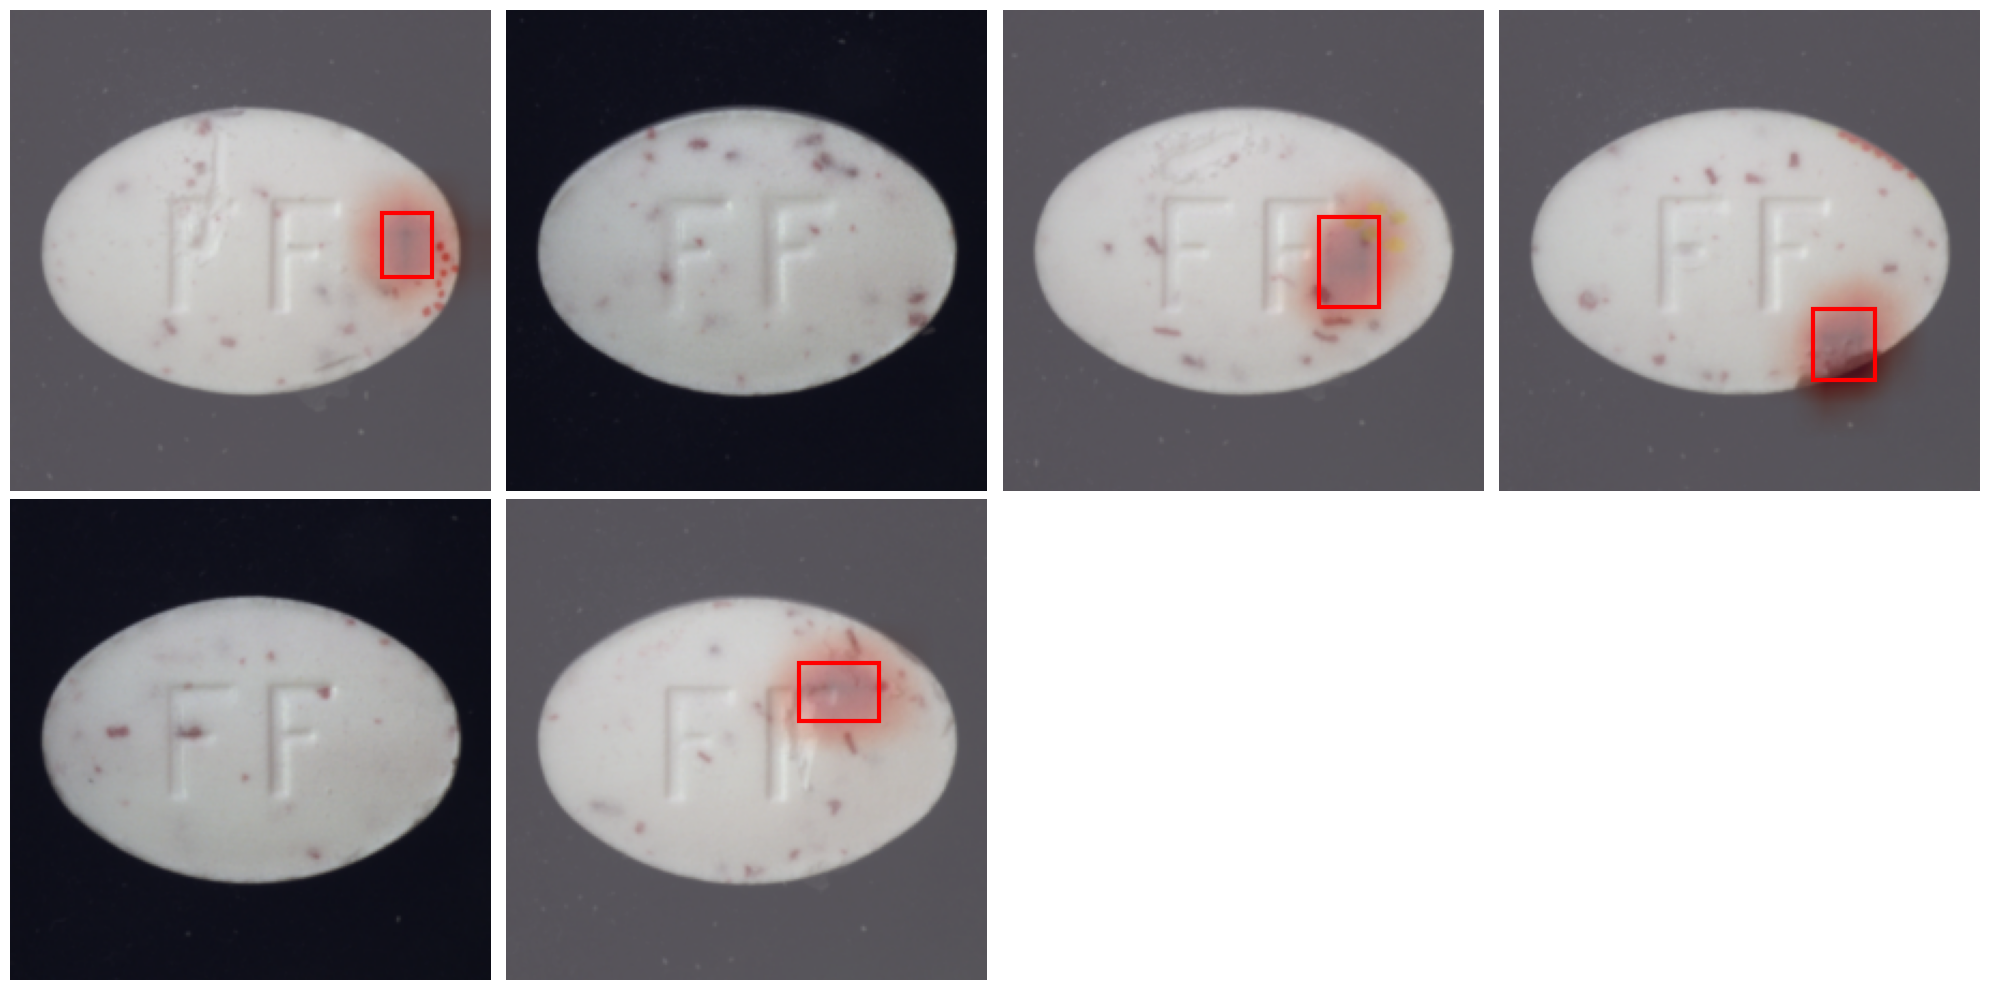

In [14]:
predict_localize(trained_model, test_loader, DEVICE, thres=HEATMAP_THRESH, n_samples=6, show_heatmap=True)

#### 样本评估和混淆矩阵 | Sample Evaluation and Confusion Matrix

In [ ]:
y_true, y_pred = evaluate(trained_model, test_loader, DEVICE, labels=True)

# <a class="anchor" id="5"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">5 | 使用 Intel® Neural Compressor 量化模型 | Quantization Model with Intel® Neural Compressor</div></a>

## <b><a class="anchor" id="1_1"><span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden">5.1 | 英特尔® Neural Compressor | Intel® Neural Compressor</span></a></b>

[Intel® Neural Compressor](https://github.com/intel/neural-compressor) 旨在为TensorFlow、PyTorch、ONNX Runtime和MXNet等主流框架以及 Intel 扩展（如Intel® Extension for TensorFlow* 和 Intel® Extension for PyTorch*）提供流行的模型压缩技术，例如量化、剪枝（稀疏性）、蒸馏和神经架构搜索。

该工具支持广泛的英特尔硬件，例如：英特尔至强可扩展处理器、英特尔至强 CPU Max 系列、英特尔数据中心 GPU Flex 系列，英特尔数据中心 GPU Max 系列，以及经过有限测试的在AMD CPU、ARM CPU 和 NVidia GPU上对 ONNX Runtime 的支持。

目前，Intel® Neural Compressor 已在10,000 多个模型上做了验证，例如Bloom-176B、OPT-6.7B、Stable Diffusion、GPT-J、BERT-Large和ResNet50 ，这些模型来自流行的模型中心，例如Hugging Face、Torch Vision和ONNX Model Zoo，通过利用零代码优化解决方案[Neural Coder](https://intel.github.io/neural_coder#what-do-we-offer)和自动 [精度驱动](https://github.com/intel/neural-compressor/blob/master/docs/source/design.md#workflow) 量化策略。

#### 使用 Intel® Neural Compressor 对模型进行量化

In [ ]:
from neural_compressor.config import PostTrainingQuantConfig, AccuracyCriterion, TuningCriterion
from neural_compressor import quantization

# INC will not quantize some layers optimized by ipex, such as _IPEXConv2d, 
# so we need to create original model object and load trained weights
model = CustomVGG()
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

# define evaluation function used by INC
def eval_func(model):
    with torch.no_grad():
        y_true = np.empty(shape=(0,))
        y_pred = np.empty(shape=(0,))

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            preds_probs = model(inputs)[0]
            preds_class = torch.argmax(preds_probs, dim=-1)
            labels = labels.to("cpu").numpy()
            preds_class = preds_class.detach().to("cpu").numpy()
            y_true = np.concatenate((y_true, labels))
            y_pred = np.concatenate((y_pred, preds_class))

    return accuracy_score(y_true, y_pred)


# quantize model
conf = PostTrainingQuantConfig(backend='ipex',
                               accuracy_criterion = AccuracyCriterion(
                                   higher_is_better=True, 
                                   criterion='relative',  
                                   tolerable_loss=0.01))
q_model = quantization.fit(model,
                           conf,
                           calib_dataloader=train_loader,
                           eval_func=eval_func)

# save quantized model
# you can also find a json file saved with quantized model, which saved quantization information for each operator
quantized_model_path = './quantized_models'
if not os.path.exists(quantized_model_path):
    os.makedirs(quantized_model_path)
q_model.save(quantized_model_path)

#### 使用量化后的模型进行推理

In [ ]:
q_model.to(DEVICE)
q_model.eval()
q_model = ipex.optimize(q_model)

y_true, y_pred = evaluate(q_model, test_loader, DEVICE, labels=True)

# <a class="anchor" id="5"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">6 | 在 Intel® oneAPI DevCloud 上运行 | Run on oneAPI DevCloud</div></a>

[Intel® oneAPI DevCloud](https://devcloud.intel.com/oneapi/) 提供了最新的第三、四代至强® 可扩展处理器，并且预装了最新的 Intel® AI Analytics Toolkit 开发环境，建议使用步骤：
1. 创建执行脚本
2. 查找满足需求的计算节点
3. 将脚本提交到指定节点，等待脚本运行完成，查询执行结果  

详细使用方法请参考 Intel® oneAPI DevCloud [开发文档](https://devcloud.intel.com/oneapi/documentation/job-submission/)

在Jupyter Notebook中提交任务并查询执行结果，请参考 [Intel® Neural Compressor Sample](https://github.com/intel/neural-compressor/blob/master/examples/notebook/pytorch/alexnet_fashion_mnist/inc_sample_for_pytorch.ipynb)

# <a class="anchor" id="5"><div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:#251cab;overflow:hidden;background:linear-gradient(100deg, navy, #251cab, #3eb4f4, #251cab)">7 | 总结与学习 | Summary and Learnings</div></a>

仅通过增加几行代码，便能够优化英特尔硬件上的自定义 VGG16 二元分类模型。借助高效的迁移学习，我们首先获取一个预训练的 torch VGG16 模型，随后使用药片数据集中的图像进行迁移学习（调优），将模型调优成一款用于药物质量控制的高效分类工具。

With just a few additions to our code, we have been able to optimize a custom VGG16 binary classification model on intel hardware. Our ability to transfer learn efficiently has allowed us to take a pre-trained torch VGG16 model and transfer learn (tune) with images from our pill dataset and turn it into an efficient classification tool for pharmaceutical quality control.

我们还学习了如何跟踪实验与构建模型仓库，以实现模型服务。这是一款强大的工具，因为它允许我们更高效地开展实验，并确保我们将性能最强劲的模型应用于生产环境中。

We also learned how to track experiments and build a model registry for model serving, This is a powerful tool because it allows us to experiment more efficiently and ensure that we are bringing the most performant models to our production environments. 

## <span style="padding:0px;color:#251cab;margin:0;font-size:100%;text-align:left;display:fill;border-radius:10px;background-color:white;overflow:hidden"> Notices & Disclaimers</span>
Intel optimizations, for Intel compilers or other products, may not optimize to the same degree for non-Intel products.  
Performance varies by use, configuration and other factors. Learn more on the Performance Index site.   
Performance results are based on testing as of dates shown in configurations and may not reflect all publicly available updates.  See backup for configuration details.  No product or component can be absolutely secure.   
Your costs and results may vary.   
Intel technologies may require enabled hardware, software or service activation.  
&copy; Intel Corporation.  Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries.  Other names and brands may be claimed as the property of others.  